# **Preprocessing Data (NO₂ Medan)**
Pada khasus ini data di processing dengan 2 cara menangani data missing value dan membuat data menjadi supervised

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

## 1.1 Menangani Missing Value  

Untuk menjaga **kontinuitas data deret waktu (time series)** dan memastikan model prediksi dapat mempelajari pola historis dengan akurat, nilai-nilai **NO₂ yang hilang (missing values)** perlu diisi kembali sebelum digunakan dalam proses pelatihan model.  

Dalam kasus ini, diterapkan **metode interpolasi linier (linear interpolation)** untuk memperkirakan nilai yang hilang berdasarkan hubungan antar data di sekitarnya.  

Metode ini dipilih karena memiliki beberapa keunggulan:  
1. **Mampu memperkirakan nilai kosong** berdasarkan kecenderungan perubahan nilai sebelum dan sesudah tanggal yang hilang.  
2. **Cocok untuk data lingkungan**, seperti konsentrasi gas NO₂, yang umumnya mengalami perubahan secara bertahap dan tidak ekstrem dari hari ke hari.  
3. **Menjaga urutan kronologis data**, karena interpolasi linier tidak mengubah struktur temporal dataset, sehingga pola waktu tetap konsisten.  

Dengan penerapan metode ini, seluruh nilai hilang pada kolom NO₂ dapat diestimasi secara logis tanpa menimbulkan distorsi pada tren data aslinya.  
Dataset hasil interpolasi kemudian siap digunakan pada tahap selanjutnya, yaitu pembentukan data *supervised learning*.

## Contoh Data

In [ ]:
NO2 = pd.read_csv('no2_results/no2_medan_data.csv')
NO2 = NO2.sort_values(by='date')
NO2

,date,feature_index,NO2
298,2024-10-01T00:00:00.000Z,0,NaN
296,2024-10-02T00:00:00.000Z,0,0.000037
297,2024-10-03T00:00:00.000Z,0,NaN
330,2024-10-04T00:00:00.000Z,0,0.000030
326,2024-10-05T00:00:00.000Z,0,0.000022
...,...,...,...
184,2025-10-27T00:00:00.000Z,0,0.000035
188,2025-10-28T00:00:00.000Z,0,0.000033
186,2025-10-29T00:00:00.000Z,0,0.000039
189,2025-10-30T00:00:00.000Z,0,NaN


/tmp/ipython-input-800750193.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",


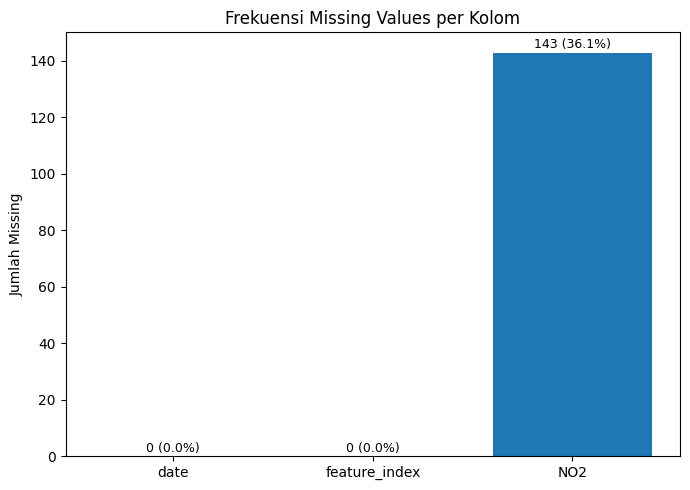

,Missing Count,Missing Percent (%)
date,0,0.00
feature_index,0,0.00
NO2,143,36.11


In [ ]:
missing_count = NO2.isnull().sum()
missing_percent = (missing_count / len(NO2)) * 100

fig, ax = plt.subplots(figsize=(7,5))

bars = ax.bar(missing_count.index, missing_count)

ax.set_title("Frekuensi Missing Values per Kolom")
ax.set_ylabel("Jumlah Missing")

for i, v in enumerate(missing_count):
    ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

In [ ]:
NO2 = pd.Series(NO2['NO2'].values, index=NO2['date'], name='NO2')
NO2 = NO2.interpolate(method='linear').bfill()
NO2 = pd.DataFrame(NO2).reset_index()
NO2

,date,NO2
0,2024-10-01T00:00:00.000Z,0.000037
1,2024-10-02T00:00:00.000Z,0.000037
2,2024-10-03T00:00:00.000Z,0.000033
3,2024-10-04T00:00:00.000Z,0.000030
4,2024-10-05T00:00:00.000Z,0.000022
...,...,...
391,2025-10-27T00:00:00.000Z,0.000035
392,2025-10-28T00:00:00.000Z,0.000033
393,2025-10-29T00:00:00.000Z,0.000039
394,2025-10-30T00:00:00.000Z,0.000039


In [ ]:
missing_count = NO2.isnull().sum()
missing_percent = (missing_count / len(NO2)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percent (%)
date,0,0.0
NO2,0,0.0


In [ ]:
NO2 = NO2.drop(columns='date')
NO2 = pd.DataFrame(NO2)
NO2

,NO2
0,0.000037
1,0.000037
2,0.000033
3,0.000030
4,0.000022
...,...
391,0.000035
392,0.000033
393,0.000039
394,0.000039


Setelah proses **interpolasi linier** dilakukan pada kolom NO₂, hasil pemeriksaan ulang menunjukkan bahwa seluruh nilai yang hilang telah berhasil diisi dengan baik.  
Dengan demikian, dataset kini **bebas dari missing value** dan siap digunakan untuk tahap berikutnya, yaitu **pemodelan prediksi konsentrasi NO₂** menggunakan metode *K-Nearest Neighbors (KNN) Regression*.  

## 2.2 Konversi ke Supervised Learning  


Pada tahap ini, dilakukan proses **konversi data deret waktu (time series)** menjadi bentuk **supervised learning** agar dapat digunakan dalam algoritma pembelajaran mesin.  
Hal ini penting karena:  

- Data *time series* pada dasarnya hanya berisi nilai-nilai berdasarkan urutan waktu.  
- Sementara *supervised learning* membutuhkan pasangan **input (X)** dan **output (y)** untuk melatih model.  

Oleh sebab itu, dilakukan transformasi dengan cara **membuat fitur keterlambatan (lag features)**, yaitu menjadikan nilai-nilai NO₂ beberapa hari sebelumnya sebagai variabel input untuk memprediksi nilai NO₂ hari berikutnya.  

Dalam penelitian ini, dilakukan eksperimen dengan menggunakan **lag 2 hingga 5 hari sebelumnya** sebagai fitur masukan.  

### Langkah-langkah Konversi:
**Menginisialisasi dataset lag 1–5 hari**, yang masing-masing akan digunakan untuk membuat data supervised.  



In [ ]:
day1 = NO2
day2 = NO2
day3 = NO2
day4 = NO2
day5 = NO2

**1. Membuat data supervised menggunakan t1**

In [ ]:
n_lags = 1
for i in range(1, n_lags + 1):
    day1[f't-{i}'] = day1['NO2'].shift(i)

day1 = day1.dropna().reset_index(drop=True)
day1.to_csv('no2_results/day1_supervised.csv', index=False)
day1

,NO2,t-1
0,0.000037,0.000037
1,0.000033,0.000037
2,0.000030,0.000033
3,0.000022,0.000030
4,0.000023,0.000022
...,...,...
390,0.000035,0.000027
391,0.000033,0.000035
392,0.000039,0.000033
393,0.000039,0.000039


**2. Membuat data supervised menggunakan t1, t2**

In [ ]:
n_lags = 2
for i in range(1, n_lags + 1):
    day2[f't-{i}'] = day2['NO2'].shift(i)

day2 = day2.dropna().reset_index(drop=True)
day2.to_csv('no2_results/day2_supervised.csv', index=False)
day2

,NO2,t-1,t-2
0,0.000033,0.000037,0.000037
1,0.000030,0.000033,0.000037
2,0.000022,0.000030,0.000033
3,0.000023,0.000022,0.000030
4,0.000024,0.000023,0.000022
...,...,...,...
389,0.000035,0.000027,0.000029
390,0.000033,0.000035,0.000027
391,0.000039,0.000033,0.000035
392,0.000039,0.000039,0.000033


**3. Membuat data supervised menggunakan t1, t2, t3**

In [ ]:
n_lags = 3
for i in range(1, n_lags + 1):
    day3[f't-{i}'] = day3['NO2'].shift(i)

day3 = day3.dropna().reset_index(drop=True)
day3.to_csv('no2_results/day3_supervised.csv', index=False)
day3

,NO2,t-1,t-2,t-3
0,0.000030,0.000033,0.000037,0.000037
1,0.000022,0.000030,0.000033,0.000037
2,0.000023,0.000022,0.000030,0.000033
3,0.000024,0.000023,0.000022,0.000030
4,0.000047,0.000024,0.000023,0.000022
...,...,...,...,...
388,0.000035,0.000027,0.000029,0.000031
389,0.000033,0.000035,0.000027,0.000029
390,0.000039,0.000033,0.000035,0.000027
391,0.000039,0.000039,0.000033,0.000035


**4. Membuat data supervised menggunakan t1, t2, t3, t4**

In [ ]:
n_lags = 4
for i in range(1, n_lags + 1):
    day4[f't-{i}'] = day4['NO2'].shift(i)

day4 = day4.dropna().reset_index(drop=True)
day4.to_csv('no2_results/day4_supervised.csv', index=False)
day4

,NO2,t-1,t-2,t-3,t-4
0,0.000022,0.000030,0.000033,0.000037,0.000037
1,0.000023,0.000022,0.000030,0.000033,0.000037
2,0.000024,0.000023,0.000022,0.000030,0.000033
3,0.000047,0.000024,0.000023,0.000022,0.000030
4,0.000046,0.000047,0.000024,0.000023,0.000022
...,...,...,...,...,...
387,0.000035,0.000027,0.000029,0.000031,0.000033
388,0.000033,0.000035,0.000027,0.000029,0.000031
389,0.000039,0.000033,0.000035,0.000027,0.000029
390,0.000039,0.000039,0.000033,0.000035,0.000027


**5. Membuat data supervised menggunakan t1, t2, t3, t4, t5**

In [ ]:
n_lags = 5
for i in range(1, n_lags + 1):
    day5[f't-{i}'] = day5['NO2'].shift(i)

day5 = day5.dropna().reset_index(drop=True)
day5.to_csv('no2_results/day5_supervised.csv', index=False)
day5

,NO2,t-1,t-2,t-3,t-4,t-5
0,0.000023,0.000022,0.000030,0.000033,0.000037,0.000037
1,0.000024,0.000023,0.000022,0.000030,0.000033,0.000037
2,0.000047,0.000024,0.000023,0.000022,0.000030,0.000033
3,0.000046,0.000047,0.000024,0.000023,0.000022,0.000030
4,0.000047,0.000046,0.000047,0.000024,0.000023,0.000022
...,...,...,...,...,...,...
386,0.000035,0.000027,0.000029,0.000031,0.000033,0.000035
387,0.000033,0.000035,0.000027,0.000029,0.000031,0.000033
388,0.000039,0.000033,0.000035,0.000027,0.000029,0.000031
389,0.000039,0.000039,0.000033,0.000035,0.000027,0.000029


Hasil dari proses ini berupa beberapa versi dataset *supervised*, masing-masing dengan kombinasi jumlah *lag features* yang berbeda.  
Dataset inilah yang selanjutnya digunakan untuk pelatihan model prediksi kualitas udara.